In [1]:
import numpy as np
import pandas as pd
import GPy
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pyplot as plt

from data.get_results import get_results
from likelihood import get_kernel
from acquisitions import phase_ucb_acq, generate, likelihood

 E:\Program_Files\Anaconda\envs\testpymc3\lib\site-packages\h5py\__init__.py:36: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


In [2]:
def plot_explore(trace, trials, midpoint=None):
    varnames = [v for v in trace.varnames if '__' not in v]
    var = np.array([trace.get_values(v)for v in varnames]).T[0][200:]
    df = pd.DataFrame(var, columns=varnames)
    
    if midpoint:
        df['x_midpoint'] = midpoint
    explore = (1 - 1. / (1 + df['yscale'][:,None] * np.exp(-df['steepness'][:,None] * (trials - df['x_midpoint'][:,None]))))
    mean = a.mean(axis=0)
    std = a.std(axis=0)
    plt.plot(mean);
    plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=.1);

In [3]:
def get_params(trace):
    varnames = [v for v in trace.varnames if '__' not in v]
    var = np.array([trace.get_values(v)for v in varnames]).T[0][200:]
    df = pd.DataFrame(var, columns=varnames)
    df['explore'] = df.apply(lambda x: (1 - 1. / (1 + x['yscale']* np.exp(-x['steepness'] * \
                                                (trials - x['x_midpoint'])))), axis=1)
    return df

In [4]:
def logistic(trials, yscale, steepness, x_midpoint):
    return 1 - 1. / (1 + yscale* np.exp(-steepness * (trials - x_midpoint)))

In [5]:
def plot_params(true_explore, trace, n):
    
    params = get_params(trace)
    plt.plot(true_explore)
    plt.plot(np.vstack(params['explore'].values[-n:]).T)
    plt.ylim((-.1, 1.1))
    plt.show()
    

In [6]:
results = get_results('data/results.json').iloc[3:]
function_names = results['function_name'].unique()
kernel_dict = {f: get_kernel(results, GPy.kern.RBF(1), f) for f in function_names}
functions_dict = results[['function_name', 'function']].drop_duplicates(subset = ['function_name']).set_index('function_name').to_dict()['function']
normalized_functions_dict = {f: np.array(functions_dict[f]) / np.std(functions_dict[f]) for f in function_names}

## Simulate actions with negative quadratic reward

In [7]:
neg_quad = normalized_functions_dict['neg_quad']
neg_quad_kern = kernel_dict['neg_quad']
fmax = np.argmax(neg_quad)

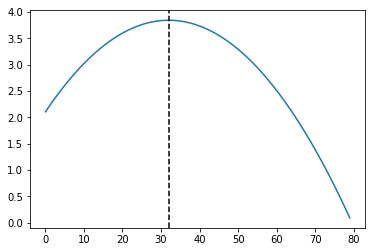

In [8]:
plt.plot(neg_quad);
plt.axvline(x=fmax, ls='--', c='black');

## Strategies

In [9]:
steepness_params = np.array([0, 100, 0, 100, .5])
x_midpoint_params = np.array([10, 20, 10, 10, 10])
yscale_params = np.array([0, 1, 1, 1, 1])
temp_params = [.00001, .0001, .001, .01]
trials = np.arange(20)
titles = ['Pure Exploit', 'Pure Explore', 'Balanced', 'Hard Phase', 'Soft Phase']

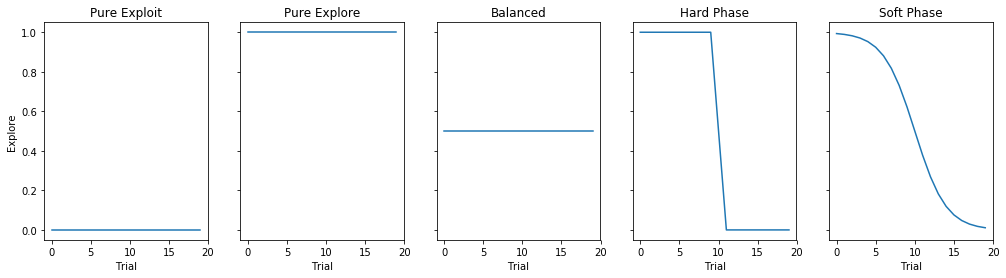

In [10]:
explore = (1 - 1. / (1 + yscale_params[:,None] * np.exp(-steepness_params[:,None] * (trials - x_midpoint_params[:,None]))))
fig, axes = plt.subplots(1, len(steepness_params), sharex=True, sharey=True, figsize=(17, 4))
for i in range(len(axes)):
    axes[i].plot(explore[i])
    axes[i].set_title(titles[i])
    if i == 0:
        axes[i].set_ylabel('Explore')
    axes[i].set_xlabel('Trial')

In [11]:
data = [[generate(phase_ucb_acq, {'steepness': [steepness_params[i]], 'x_midpoint': [x_midpoint_params[i]],
                                  'temperature': [temp_params[j]], 'yscale': [yscale_params[i]]},
        neg_quad_kern, neg_quad, 20, 10, 1, [1.])[0] for i in range(len(steepness_params))] for j in range(len(temp_params))]

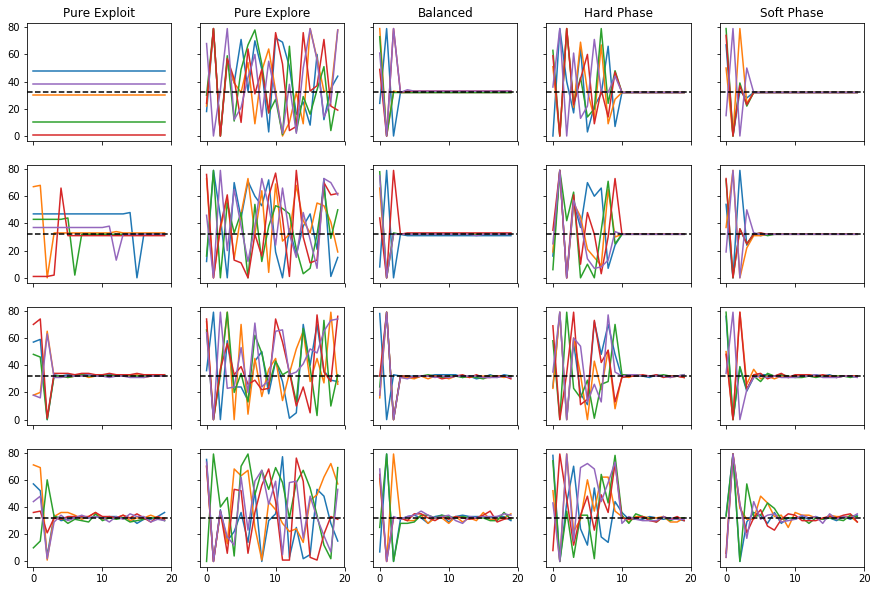

In [12]:
fig, axes = plt.subplots(len(temp_params), len(x_midpoint_params), sharex=True, sharey=True, figsize=(15,10))
for j in range(len(temp_params)):
    for i in range(len(x_midpoint_params)):
        actions = data[j][i][:,:,5].argmax(axis=2)
        axes[j][i].plot(actions[:5].T);
        axes[j][i].axhline(y=fmax, ls='--', c='black');
        if j == 0:
            axes[j][i].set_title(titles[i])

## Pure Exploit

In [13]:
with pm.Model() as model:
    steepness = pm.Gamma('steepness', 1., 1., shape=1)
    x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=1)
    yscale = pm.Gamma('yscale', 1., 1., shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][0], phase_ucb_acq, {'steepness': steepness, 
                               'temperature': temperature, 'x_midpoint': x_midpoint,
                               'yscale': yscale}, 1, [1.]))
    exploit_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, yscale, x_midpoint, steepness]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:14<00:00, 199.03draws/s]
There were 184 divergences after tuning. Increase `target_accept` or reparameterize.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


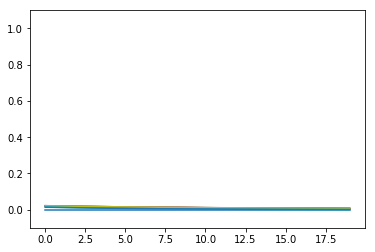

In [14]:
plot_params(explore[0], exploit_trace, 10)

## Pure Explore

In [15]:
with pm.Model() as model:
    steepness = pm.Gamma('steepness', 1., 1., shape=1)
    x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=1)
    yscale = pm.Gamma('yscale', 1., 1., shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][1], phase_ucb_acq, {'steepness': steepness, 
                               'temperature': temperature, 'x_midpoint': x_midpoint,
                               'yscale': yscale}, 1, [1.]))
    explore_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, yscale, x_midpoint, steepness]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:18<00:00, 150.82draws/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


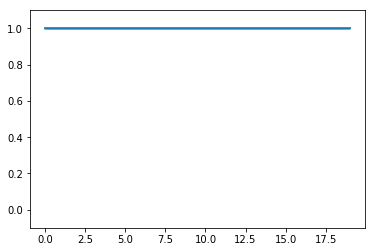

In [16]:
plot_params(explore[1], explore_trace, 10)

## Balanced

In [17]:
with pm.Model() as model:
    steepness = pm.Gamma('steepness', 1., 1., shape=1)
    x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=1)
    yscale = pm.Gamma('yscale', 1., 1., shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][2], phase_ucb_acq, {'steepness': steepness, 
                               'temperature': temperature, 'x_midpoint': x_midpoint,
                               'yscale': yscale}, 1, [1.]))
    balanced_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, yscale, x_midpoint, steepness]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:20<00:00, 46.77draws/s] 
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6931103899236871, but should be close to 0.8. Try to increase the number of tuning steps.
There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


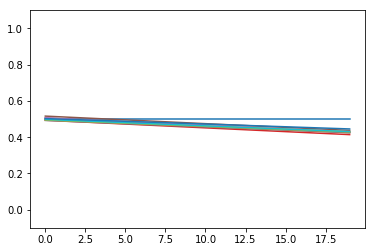

In [18]:
plot_params(explore[2], balanced_trace, 10)

## Hard Phase

In [19]:
with pm.Model() as model:
    steepness = pm.Gamma('steepness', 1., 1., shape=1)
    x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=1)
    yscale = pm.Gamma('yscale', 1., 1., shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][3], phase_ucb_acq, {'steepness': steepness, 
                               'temperature': temperature, 'x_midpoint': x_midpoint,
                               'yscale': yscale}, 1, [1.]))
    hp_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, yscale, x_midpoint, steepness]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:18<00:00, 147.89draws/s]
The acceptance probability does not match the target. It is 0.8903037201944664, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


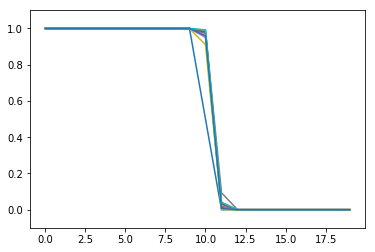

In [20]:
plot_params(explore[3], hp_trace, 10)

## Soft Phase

In [21]:
with pm.Model() as model:
    steepness = pm.Gamma('steepness', 1., 1., shape=1)
    x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=1)
    yscale = pm.Gamma('yscale', 1., 1., shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][4], phase_ucb_acq, {'steepness': steepness, 
                               'temperature': temperature, 'x_midpoint': x_midpoint,
                               'yscale': yscale}, 1, [1.]))
    sp_trace = pm.sample(600)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, yscale, x_midpoint, steepness]
Sampling 4 chains: 100%|██████████| 4400/4400 [06:05<00:00,  2.39draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


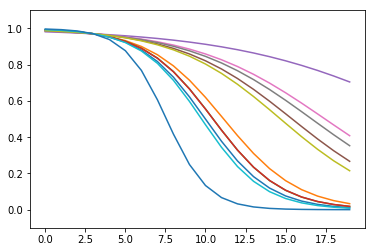

In [22]:
plot_params(explore[4], sp_trace, 10)